In [79]:
import gym
import gym_kraby
import math as maths
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from copy import deepcopy as DC


# Simulation

In [80]:
class hexapod:
    def __init__(self):
        self.env= gym.make('gym_kraby:HexapodBulletEnv-v0', render=True)
        obs=self.env.reset()
        self.action_space=self.env.action_space.sample()  # take a random action
        self.sensors={"foot_0":4,"endcap_0":5,"foot_1":10,"endcap_1":11,
            "foot_2":16,"endcap_2": 17,"foot_3": 22,"endcap_3": 23,
            "foot_4": 28,"endcap_4": 29,"foot_5": 34,"endcap_5":35}
    def list_feet(self):
        _link_name_to_index = {self.env.p.getBodyInfo(self.env.robot_id)[0].decode('UTF-8'):-1,}
        for _id in range(self.env.p.getNumJoints(self.env.robot_id)):
            _name = self.env.p.getJointInfo(self.env.robot_id, _id)[12].decode('UTF-8')
            _link_name_to_index[_name] = _id
            if "endcap" in _name or "foot" in _name:
                print(_name,_id)
    def reset(self):
        obs=self.env.reset()
    def step(self,a):
        """
        step through environment with action a
        return reward and the force on the feet that are contacted numbered 0-5 for each leg
        """
        observation, reward, done, _ = self.env.step(a)  # step
        filtered=self.getContact()
        return reward,filtered
    def getAngles(self):
        a=[self.getAngle(i) for i in range(18)]
        return np.array(a)
    def getContact(self):
        VALS=np.array([[5,4],[11,10],[17,16],[23,22],[29,28],[35,34]])
        contact=self.env.p.getContactPoints(bodyA=self.env.robot_id)
        a_=np.array([[5,0],[11,0],[17,0],[23,0],[29,0],[35,0]])
        for c in contact:
            p=c[3]
            f=c[9]
            if p in VALS.flatten():
                id=np.where(VALS == p)
                id=[id[0],id[1]][0]
                if a_[id[0]][0]==p: a_[id[0]][1]=f
                elif a_[id[0]][1]<f: #largest force saves
                    a_[id[0]][0]=p
                    a_[id[0]][1]=f
        return a_
    def getAngle(self,num):
        JOINT=[1,2,4,7,8,10,13,14,16,19,20,22,25,26,28,31,32,34]
        b=self.env.p.getJointState(self.env.robot_id,JOINT[num])
        d=b[0]#convert to degrees
        return (maths.pi/2)+d
    def getImage(self):
        img = self.env.p.getCameraImage(224, 224, renderer=self.env.p.ER_BULLET_HARDWARE_OPENGL)
        return img[2]
    def close(self):
        self.env.close()
    

In [81]:
robot=hexapod()

error: Only one local in-process GUI/GUI_SERVER connection allowed. Use DIRECT connection mode or start a separate GUI physics server (ExampleBrowser, App_SharedMemoryPhysics_GUI, App_SharedMemoryPhysics_VR) and connect over SHARED_MEMORY, UDP or TCP instead.

In [ ]:
a=np.zeros_like(robot.action_space)
num=0
a[num]=-0.5
robot.step(a)
robot.getAngles()

c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


array([1.1659377 , 1.1211105 , 1.94477963, 2.11962247, 1.26720233,
       1.65790363, 1.94309026, 1.16857694, 1.60701299, 1.76148634,
       1.91160284, 1.64393664, 1.61010808, 1.6635139 , 2.2772873 ,
       2.27337677, 1.39619027, 2.16921012])

0.16547435398346028


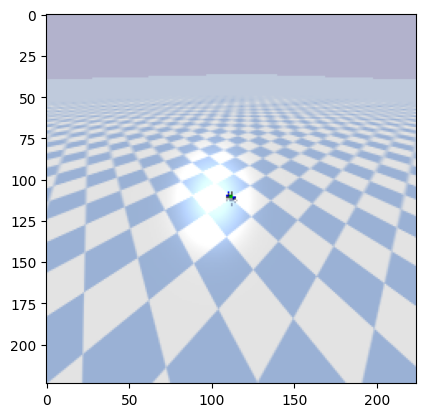

In [ ]:
cubePos, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
start=np.array(cubePos[0:3])
for i in range(10):
    #clear_output()
    r,f=robot.step(np.zeros_like(robot.action_space)+1)
    cubePos, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
end=np.array(cubePos[0:3])
d=np.sqrt(np.sum(end-start)**2)
print(d)
plt.imshow(robot.getImage())


In [ ]:
def moveX(a,vals=[1,-1,1,-1,1,-1]):
    j=1
    for j,i in enumerate(range(0,len(a),3)):
        a[i+1]=vals[j]
        a[i+2]=vals[j]
    return a
def moveY(a,vals=[1,1,1,1,1,1]):
    for i,j in enumerate(range(0,len(a),3)):
        a[j]=vals[i]
    return a

# Agent

In [82]:
#from scipy import signal
#from scipy import misc


class HopLayer:
    def __init__(self,inputs,number_of_nets,number_of_nodes,outputs):
        """
        Initialize weights
        """
        self.i,self.hn,self.ho,self.hi=inputs,number_of_nets,number_of_nodes,outputs
        self.inputs_to_hop=np.ones((self.i,self.ho,self.hn))
        self.inputs_to_hid=np.ones((self.i,self.hi))
        self.hop_to_hid=np.ones((self.ho,self.hi,self.hn))
        self.hop_weights=np.ones((self.ho,self.ho,self.hn))
        for i in range(self.hn):
            np.fill_diagonal(self.hop_weights[:,:,i], 0) #hopfield does not connect to itself
        self.num_genes=len(self.inputs_to_hop.flatten())+len(self.inputs_to_hid.flatten())+len(self.hop_to_hid.flatten())+len(self.hop_weights.flatten())
    def set_genes(self,genes,hopW=False):
        idx1,idx2,idx3=len(self.inputs_to_hop.flatten()),len(self.inputs_to_hid.flatten()),len(self.hop_to_hid.flatten())
        self.inputs_to_hop=genes[0:idx1].reshape((self.i,self.ho,self.hn))
        self.inputs_to_hid=genes[idx1:idx1+idx2].reshape((self.i,self.hi))
        self.hop_to_hid=genes[idx1+idx2:idx3+idx2+idx1].reshape((self.ho,self.hi,self.hn))
        if hopW: self.hop_weights=genes[idx3+idx2+idx1:].reshape((self.ho,self.ho,self.hn))

    def forward(self,x,iter=1):
        o1=np.dot(x,self.inputs_to_hid) #multiply through linear layer
        #o2=np.zeros((x.shape[0],))
        o2=np.zeros((x.shape[0],self.ho,self.hn))
        for i in range(self.hn): #multiply through to next
            o2[:,:,i]=np.dot(x,self.inputs_to_hop[:,:,i])
        #run hopfield inner weights
        for j in range(iter): #how many iterations in each
            for i in range(self.hn): #multiply through to next
                o2[:,:,i]=np.dot(o2[:,:,i],self.hop_weights[:,:,i]) #forward pass
                o2[:,:,i]= 1 / (1 + np.exp(-o2[:,:,i])) #sigmoid activation
        o3=np.zeros((x.shape[0],self.hi,self.hn))
        for i in range(self.hn): #multiply through to next
            o3[:,:,i]=np.dot(o2[:,:,i],self.hop_to_hid[:,:,i])
        #get linear output
        return np.sum(o3,axis=-1)+o1 
    def run(self,y,t,i):
        states=np.zeros((t,self.ho))
        states[0]=y
        for j in range(1,t): #how many iterations in each
            states[j]=np.dot(states[j-1],self.hop_weights[:,:,i]) #forward pass
            states[j]= 1 / (1 + np.exp(-states[j])) #sigmoid activation
        return states
    def train(self,labels,num=50):
        #get processed input
        for label in labels:
            label=label.reshape(1,label.shape[0])
            o2=np.zeros((label.shape[0],self.ho,self.hn))
            for i in range(self.hn): #multiply through to next
                o2[:,:,i]=np.dot(label,self.inputs_to_hop[:,:,i])
            for k in range(self.hn):
                states=self.run(o2[:,:,k],num,k)
                n=states.shape[1]
                for i in range(len(self.hop_weights)):
                    for j in range(len(self.hop_weights[i])):
                        if i!=j:
                            self.hop_weights[:,:,k][i][j]=(1/n)*np.sum(states[:,i]*states[:,j]) #hebbian learning

class network:
    def __init__(self,legs):
        self.legNo=legs
        self.legs=HopLayer(5,1,3,6) #ground sense, leg x move, leg y move, leg z move, signal -> x back x forward y back y forward
        self.internal=HopLayer(24,1,4,legs*2) #ground sense, leg x move and leg y move and leg z
        self.num_genes=self.legs.num_genes+self.internal.num_genes
    def set_genes(self,genes):
        idx1=self.legs.num_genes
        idx2=self.internal.num_genes+idx1
        self.legs.set_genes(genes[0:idx1])
        self.internal.set_genes(genes[idx1:idx2],hopW=True)
    def forward(self,sensors,movements):
        x=np.concatenate((sensors.flatten(),movements.flatten()))
        out=self.internal.forward(x.reshape(1,x.shape[0]))
        out=out.reshape(self.legNo,2)
        out[out>0]=1 #activate
        out[out<0]=0
        out=np.argmax(out,axis=1) #get activations
        motors=np.zeros((self.legNo,2))
        for i in range(self.legNo): #loop through legs
            if out[i]!=0:
                x=np.concatenate(([sensors[i]],movements[i],[out[i]])) #get sensor
                x=x*out[i]
                y=np.argmax(self.legs.forward(x.reshape(1,x.shape[0])).reshape(2,3),axis=1).astype(float)
                y[y==0]=0 #activation back
                y[y==1]=0.4 #activation forward
                y[y==2]=-0.4 #activation stop
                motors[i]=y
        return motors
    def train(self,label,num=50):
        self.legs.train(label,num=num)
a=network(6)
print(a.num_genes)
genotype=np.random.normal(0,5,(a.num_genes,))
a.set_genes(genotype)
a.train(np.ones((1,5))*(maths.pi/2))
for i in range(10):
    #clear_output()
    out=a.forward(np.random.random_integers(0,20,(6)),np.random.random_integers(0,20,(6,3)))

print(out)

520
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


C:\Users\dexte\AppData\Local\Temp\ipykernel_34772\3523057730.py:101: DeprecationWarning: This function is deprecated. Please call randint(0, 20 + 1) instead
  out=a.forward(np.random.random_integers(0,20,(6)),np.random.random_integers(0,20,(6,3)))
C:\Users\dexte\AppData\Local\Temp\ipykernel_34772\3523057730.py:35: RuntimeWarning: overflow encountered in exp
  o2[:,:,i]= 1 / (1 + np.exp(-o2[:,:,i])) #sigmoid activation


In [ ]:
horizontal=out[:,0]
vertical=out[:,1]
print(horizontal,vertical)

[0.  0.  0.2 0.  0.  0. ] [0. 0. 0. 0. 0. 0.]


# Genetic algorithm

In [83]:
def mutate(geno):
    geno+=np.random.normal(0,3,(geno.shape))
    geno[geno>12]=12
    geno[geno<-12]=-12
    return 

def gen_genotype(shape): #generate a genotype of 1 and 0
    return np.random.normal(0,5,(shape))

def gen_pop(size,pergeno):
    return gen_genotype(size*pergeno).reshape((size,pergeno))
def fitness(robot,start):
    cubePos, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
    start=np.array(start)
    cubePos=np.array(cubePos)
    orient=(np.array(cubeOrn)*10).astype(int)[0:3] #x y and z tilt
    max_tilt=np.sum(np.abs(orient))
    return max((np.linalg.norm(start[0:2]-cubePos[0:2])*0.6)-(max_tilt/10+cubePos[-1])*0.4,0)#max distance of x and y
def getFallen():
    cubePos, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
    if cubePos[-1]<0: return True
    return False
def runTrial(agent,robot,T):
    dt=0.02
    robot.reset()
    done=False
    a=np.zeros_like(robot.action_space) #first step don't move
    cum_r=0
    t=0
    fl=-1
    fx=0
    energyConsumption=0
    start, cubeOrn = robot.env.p.getBasePositionAndOrientation(robot.env.robot_id)
    while t<T and not done:
        r,c=robot.step(a)
        f=c[:,1] #get forces
        angles=robot.getAngles().reshape(6,3)
        #m=np.sum(a.reshape(6,3),axis=1)
        assert c.shape[0]==6 and angles.shape[0]==6, "Incorrect shapes"
        out=agent.forward(c[:,1],angles)
        horizontal=out[:,0]
        vertical=out[:,1]
        a=a*0 #reset
        a=moveX(a,vals=horizontal) #get x motor positions
        a=moveY(a,vals=vertical) #get y motor positions
        cum_r+=r
        f_=fitness(robot,start)
        if f_>fl:
            fx+=f_
        #energyConsumption+=np.sum(np.abs(a))/(len(a))
        #if cum_r<-10:
        #    done=True
        t+=dt
    #f=fitness(robot,start)
    return max((fx-energyConsumption)/(T/dt),0)

def run(agent,robot,population,generations=500,T=2):
    pop_size=len(population)
    shape=population.shape[1]
    fitness_matrix=np.zeros((pop_size))
    overTime=np.zeros((generations,))
    gen=0
    try:
        while gen < (generations) and overTime[max(gen-1,0)]<1:
            clear_output()
            print("Generation:",gen,"Fitness",overTime[max(gen-1,0)])
            #get mask to select genotypes for battle
            mask=np.random.choice([0, 1], size=pop_size)
            inds=(mask==1).nonzero()[0]
            while len(inds)%2!=0:
                mask=np.random.choice([0, 1], size=pop_size)
                inds=(mask==1).nonzero()[0]
            #get indicies and tournament modes
            inds=inds.reshape(len(inds)//2,2).astype(int)
            fitnesses=np.zeros((len(inds)//2)).astype(int)
            new_inds=np.zeros((len(inds)//2,2)).astype(int)
            #run each trial
            for i in range(len(inds)//2):
                #select genotypes
                g1=population[inds[i][0]]
                g2=population[inds[i][1]]
                #tournament
                agent.set_genes(g1)
                f1=0
                for j in range(3):
                    f1+=runTrial(agent,robot,T)
                f1/=3
                agent.set_genes(g1)
                f2=0
                for j in range(3):
                    f2+=runTrial(agent,robot,T)
                f2/=3
                fitness_matrix[inds[i][0]]=f1
                fitness_matrix[inds[i][1]]=f2
                if f1>f2:
                    fitnesses[i]=f1
                    new_inds[i]=[0,i]
                elif f2>f1:
                    fitnesses[i]=f2
                    new_inds[i]=[1,i]
                else:
                    fitnesses[i]=0
                    new_inds[i]=[0,i]
                print(np.max(fitness_matrix))
                if getFallen():
                    clear_output()
            if getFallen():
                clear_output()
                np.save("model_hex_newNet1",population)
                print("THE SIMULATION BROKE")
                break
            #get top values and redistribute into the array
            winners=int(len(inds)//2 *0.4)
            mutants=int(len(inds)//2 *0.4)
            other=len(inds)//2 -winners - mutants
            order=np.argsort(fitnesses)
            for i in reversed(range(len(inds)//2)): #loop through backwards leaving the winners in place
                genoWin=new_inds[i][0]
                old_index=new_inds[i][1]
                if i<(len(inds)//2)-winners and i>(len(inds)//2)-winners-mutants: #pick mutants
                    population[inds[old_index][1-genoWin]]=mutate(DC(population[inds[old_index][genoWin]])) #mutate copy
                elif i<(len(inds)//2)-winners-mutants: #the other
                    population[inds[old_index][1-genoWin]]=gen_genotype(shape=shape) #create new genotype
            overTime[gen]=np.max(fitness_matrix)
            gen+=1
    except KeyboardInterrupt:
        np.save("model_hex_newNet1",population)
    return overTime

## create agent and genes

In [85]:
agent=network(6)
agent.train(np.ones((1,5))*(maths.pi/2))
population=gen_pop(50,agent.num_genes) #create population
try: population=np.load("model_hex_newNet1") #if exists
except: pass


genotype=np.random.normal(0,5,(agent.num_genes,))
agent.set_genes(population[0])
run(agent,robot,population,generations=500,T=2)

Generation: 20 Fitness 0.0011118035807345845


array([0.0034595 , 0.02302317, 0.00049261, 0.00175292, 0.00049261,
       0.0005591 , 0.00118125, 0.00234334, 0.00118125, 0.00118125,
       0.00650377, 0.00650377, 0.00650377, 0.00160467, 0.00497743,
       0.00497743, 0.00497743, 0.00209814, 0.00110009, 0.0011118 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     